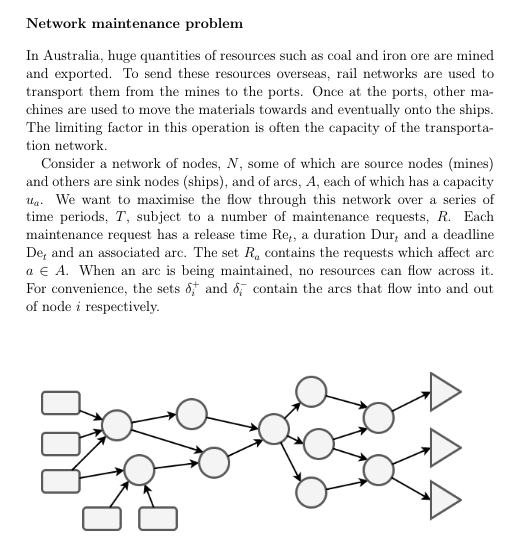

Abstract benders
- Logic based Benders (Sub Problem is IP or an inspection problem)
- Classical Benders (Sub Problem is LP)

### Sets
- N: Nodes
- A: Arcs
- T: Time periods
- J: Jobs (Requests)
- $\delta^+_i$: Arcs into node i
- $\delta^-_i$: Arcs into node i
- $J_a$: jobs that impact arc a

### Data
- $u_a$: upper bound on each arc
- $J_{ta}$: set of (j, t') such that if job j starts at time t', arc a is closed at time t, s.t. $j \in J_a$, $t' \in Start_j$
- $Start_j$: set of starting times for job j
- $\omega$: index of back arc  



### Variables
- $y_{jt} \in \{0,1\}$: 1 if job j operates at time t, $j \in J, t \in Start_j$
- $x_{at} \geq 0$: Flow on arc a at time period t

### Objective
Maximise flow on back ark
$$
\max \sum_{t \in T} x_{\omega t}
$$

### Constraints
Run every job exactly once
$$
\sum_{t \in Start_j} y_{jt} = 1 \forall j \in J
$$

Conserve flow at each node in each time period
$$
\sum_{a \in \delta^+_i} x_{at} = \sum_{a \in \delta^-_i} x_{at}   \forall i \in N, \forall t \in T
$$

Upper Bound
$$
x_{at} \leq u_{at} (1 - \sum_{(j,t') \in J_{ta}} y_{jt'}) \forall a \in A, \forall t \in T
$$

In [8]:
import gurobipy as gp

# Initialise empty data
Nodes = []
Arcs = []
BackArc = None
FromNode = -1

# Read in the data
with open('Outmax_flow2.dat') as f:
    while True:
        l = f.readline().strip()
        if l[0]=='n':
            FromNode = len(Nodes)
            Nodes.append(l)
        elif l[0]=='a':
            t = l.split(' ')
            flow = int(t[4])
            ToNode = int(t[3])
            if flow==10000:
                BackArc = len(Arcs)
            Arcs.append((FromNode,ToNode,flow))
        else:
            break
N = range(len(Nodes))
A = range(len(Arcs))

print('Nodes and Arcs', len(Nodes), len(Arcs))

# Empty array of jobs
Jobs = []
with open('max_flow2.dat_Job0') as f:
    while True:
        l = f.readline().strip()
        if len(l) <= 1:
            break
        nArc = int(l.split(' ')[1])
        t = f.readline().strip().split(' ')
        Jobs.append((nArc,int(t[1])-1,int(t[2])-1,int(t[3])))
        
T = range(1000)
J = range(len(Jobs))
# The jobs for an arc
JobsA = [[j for j in J if Jobs[j][0]==a] for a in A]
# The starting time periods for job A
JP = [range(Jobs[j][1], Jobs[j][2]) for j in J]

print('Jobs', len(Jobs))
# The jobs and their indices that impact on arc a in time t
JobsTA = [[[(j,p) for j in JobsA[a] for p in JP[j] if p<=t and p+Jobs[j][3]>t] for a in A] for t in T]
print('Calculated JobsTA')

m = gp.Model('Network Maintenance')

Y = {(j ,t): m.addVar(vtype=gp.GRB.BINARY) for j in J for t in JP[j]}
X = {(a,t): m.addVar() for a in A for t in T}

EachJobOnce = {
    j:
    m.addConstr(gp.quicksum(Y[j, t] for t in JP[j]) == 1)
    for j in J
}

ConserveFlow = {
    (n, t):
    m.addConstr(
        gp.quicksum(X[a, t] for a in A if Arcs[a][0] == n)
        == gp.quicksum(X[a, t] for a in A if Arcs[a][1] == n)
    )
    for n in N for t in T
}

ArcBound = {
    (a, t):
    m.addConstr(
        X[a, t]
        <= Arcs[a][2] * (1 - gp.quicksum(Y[j, tt] for (j, tt) in JobsTA[t][a]))
    )
    for a in A for t in T
}

m.setObjective(
    gp.quicksum(X[BackArc, t] for t in T),
    gp.GRB.MAXIMIZE
)

m.Params.MIPGap = 0
m.Params.Threads = 8

m.optimize()


Nodes and Arcs 16 45
Jobs 398
Calculated JobsTA
Set parameter MIPGap to value 0
Set parameter Threads to value 8
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G84)

CPU model: Apple M4 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 8 threads

Non-default parameters:
MIPGap  0
Threads  8

Optimize a model with 61398 rows, 52160 columns and 278149 nonzeros
Model fingerprint: 0x55e6d566
Variable types: 45000 continuous, 7160 integer (7160 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Found heuristic solution: objective -0.0000000
Presolve removed 39364 rows and 18076 columns
Presolve time: 0.24s
Presolved: 22034 rows, 34084 columns, 163673 nonzeros
Found heuristic solution: objective 798.0000000
Variable types: 28021 continuous, 6063 integer (6063 binary)
Deterministic concurrent LP optimizer: primal and dual si

### BMP

Theta_t is an estimiate of throughput in sub problem t

$$
\max \sum_{t \in T} \theta_t
$$

such that

$$
\sum_{t \in Start_j} y_{jt} = 1 \forall j \in J
$$

$$
\theta_t \leq MaxFlow \forall t \in T
$$

### BSP_t

$$
\max x_{\omega t}
$$

such that

conservation of flow ($\lambda^k_{it}$)
$$
\sum_{a \in \delta^+_i} x_{at} = \sum_{a \in \delta^-_i} x_{at}   \forall i \in N
$$

$\pi_{at}^k$
$$
x_{at} \leq u_{at} (1 - \sum_{(j, t') \in J_{ta}} y^*_{j t'}) \forall a \in A
$$

### Benders cut
Only add cut when theta t is bigger than the objective value of sub problem t
$$
\theta_t \leq \sum_{a \in A} \pi_{at}^k u_{at} (1 - \sum_{(j, t') \in J_{ta}} y_{j t'}) \forall t \in T
$$

In [ ]:
import gurobipy as gp

EPS = 1e-4

# Initialise empty data
Nodes = []
Arcs = []
BackArc = None
FromNode = -1

# Read in the data
with open('Outmax_flow2.dat') as f:
    while True:
        l = f.readline().strip()
        if l[0]=='n':
            FromNode = len(Nodes)
            Nodes.append(l)
        elif l[0]=='a':
            t = l.split(' ')
            flow = int(t[4])
            ToNode = int(t[3])
            if flow==10000:
                BackArc = len(Arcs)
            Arcs.append((FromNode,ToNode,flow))
        else:
            break
N = range(len(Nodes))
A = range(len(Arcs))

print('Nodes and Arcs', len(Nodes), len(Arcs))

# Empty array of jobs
Jobs = []
with open('max_flow2.dat_Job0') as f:
    while True:
        l = f.readline().strip()
        if len(l) <= 1:
            break
        nArc = int(l.split(' ')[1])
        t = f.readline().strip().split(' ')
        Jobs.append((nArc,int(t[1])-1,int(t[2])-1,int(t[3])))
        
T = range(1000)
J = range(len(Jobs))
# The jobs for an arc
JobsA = [[j for j in J if Jobs[j][0]==a] for a in A]
# The starting time periods for job A
JP = [range(Jobs[j][1], Jobs[j][2]) for j in J]

print('Jobs', len(Jobs))
# The jobs and their indices that impact on arc a in time t
JobsTA = [[[(j,p) for j in JobsA[a] for p in JP[j] if p<=t and p+Jobs[j][3]>t] for a in A] for t in T]
print('Calculated JobsTA')


##########################################################################################
### SUB PROBLEM
BSP = gp.Model('Benders Subproblem')
BSP.Params.OutputFlag = 0  # Do not print output

X = {a: BSP.addVar() for a in A}

ConserveFlow = {
    n:
    BSP.addConstr(
        gp.quicksum(X[a] for a in A if Arcs[a][0] == n)
        == gp.quicksum(X[a] for a in A if Arcs[a][1] == n)
    )
    for n in N
}

ArcBound = {
    a:
    BSP.addConstr(
        X[a]
        <= 
        Arcs[a][2]
        # Arcs[a][2] * (1 - gp.quicksum(Y[j, tt] for (j, tt) in JobsTA[t][a]))
    )
    for a in A
}

BSP.setObjective(
    X[BackArc],
    gp.GRB.MAXIMIZE
)

BSP.optimize()



##########################################################################################
### MASTER PROBLEM
BMP = gp.Model('Network Maintenance')

Y = {(j ,t): BMP.addVar(vtype=gp.GRB.BINARY) for j in J for t in JP[j]}
Theta = {t: BMP.addVar(ub=BSP.ObjVal) for t in T}

EachJobOnce = {
    j:
    BMP.addConstr(gp.quicksum(Y[j, t] for t in JP[j]) == 1)
    for j in J
}

BMP.setObjective(
    gp.quicksum(Theta[t] for t in T),
    gp.GRB.MAXIMIZE
)

BMP.Params.MIPGap = 0
BMP.Params.Threads = 8
BMP.Params.LazyConstraints = 1
BMP.Params.BranchDir = 1  # Find INT solutions quickly



##########################################################################################
### CALL BACK
_SolutionCache = {}
def SolveSub(ArcsOff):
    if ArcsOff not in _SolutionCache:
        # Turn arcs that are off to have a right hand side of 0 
        for a in ArcsOff:
            ArcBound[a].RHS = 0

        # Solve the sub problem
        BSP.optimize()

        # Return Objective value and dual variables of arc bounds
        _SolutionCache[ArcsOff] = (
            BSP.ObjVal,
            {a: ArcBound[a].pi for a in A}
        )

        # Set the RHS back
        for a in ArcsOff:
            ArcBound[a].RHS = Arcs[a][2]

    return _SolutionCache[ArcsOff]


BMP._BestSolution = 0


def Callback(model, where):
    if where == gp.GRB.Callback.MIPSOL:
        YV = model.cbGetSolution(Y)
        ThetaV = model.cbGetSolution(Theta)

        # Add cut for each time period
        CutsAdded = 0
        for t in T:
            ArcsOff = tuple(
                a for a in A 
                if round(sum(YV[j, tt] for (j, tt) in JobsTA[t][a])) == 1
            )
            ObjVal, DualDict = SolveSub(ArcsOff)

            # Make cut!
            if ObjVal < ThetaV[t] - EPS:

                ### Primal Hueritics
                ThetaV[t] = ObjVal
                CutsAdded += 1
                ###

                model.cbLazy(
                    Theta[t]
                    <=
                    gp.quicksum(
                        DualDict[a] 
                        * Arcs[a][2] 
                        * (1 - gp.quicksum(Y[j, tt] for (j, tt) in JobsTA[t][a]))
                        for a in A
                    )
                )

        ### Primal Hueritics
        # if we have made no cuts and total throughput of all subproblems is greater than the current soluition
        # We know (hueristic due to real world knowledge) that this must be the better solition
        if CutsAdded == 0 and sum(ThetaV.values()) > BMP._BestSolution + EPS:
            BMP._BestSolution = sum(ThetaV.values())

            if BMP._BestSolution > model.cbGet(gp.GRB.Callback.MIPSOL_OBJBST) + EPS:
                print(f"Posting {BMP._BestSolution}")
                # We found better solution!!!!
                model.cbSetSolution(Y, YV)
                model.cbSetSolution(Theta, ThetaV)



### Warm Start!
# Relax
for v in Y.values():
    v.VType = gp.GRB.CONTINUOUS

for k in range(10):
    BMP.optimize()
    CutsAdded = 0
    for t in T:
        for a in A:
            ArcBound[a].RHS = (1 - sum(Y[j, tt].x for (j, tt) in JobsTA[t][a]))
        BSP.optimize()
        if BSP.ObjVal < Theta[t].x - EPS:
            CutsAdded += 1
            BMP.addConstr(
                Theta[t]
                <=
                gp.quicksum(
                    ArcBound[a].pi 
                    * Arcs[a][2] 
                    * (1 - gp.quicksum(Y[j, tt] for (j, tt) in JobsTA[t][a]))
                    for a in A
                )
            )
    if CutsAdded == 0:
        break
    print(f"{'*'*50}\n {CutsAdded=}, {BMP.ObjVal=} \n{'*'*50}")

# Revert
for v in Y.values():
    v.VType = gp.GRB.BINARY
    


BMP.optimize(Callback)
#BMP.optimize()



Nodes and Arcs 16 45
Jobs 398
Calculated JobsTA
Set parameter MIPGap to value 0
Set parameter Threads to value 8
Set parameter LazyConstraints to value 1
Set parameter BranchDir to value 1
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G84)

CPU model: Apple M4 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 8 threads

Non-default parameters:
MIPGap  0
BranchDir  1
Threads  8
LazyConstraints  1

Optimize a model with 398 rows, 8160 columns and 7160 nonzeros
Model fingerprint: 0x9a01f287
Variable types: 1000 continuous, 7160 integer (7160 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 6e+01]
  RHS range        [1e+00, 1e+00]
Presolve removed 19 rows and 19 columns
Presolve time: 0.01s
Presolved: 379 rows, 8141 columns, 7135 nonzeros
Variable types: 1000 continuous, 7141 integer (7141 binary)

Root relaxation: objective 5.126600e+04, 778 iterations, 0.00

No Strat: 165s
+ BranchingDir=1: 95s
+ Primal hureitics: 95s
+ Warm Starts:

In [12]:
len(_SolutionCache)

6577